In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from matplotlib import gridspec
from matplotlib import patches

import os
import math

import xgboost
from xgboost import XGBRegressor, XGBClassifier

from sklearn.utils import shuffle

import random

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d

In [2]:
#################
# LOAD THE DATA #
#################

df_test = pd.read_hdf('events_anomalydetection_v2.features.h5')#,stop=10000)
print(df_test.shape)
print("Memory in GB:",sum(df_test.memory_usage(deep=True)) / (1024**3))

df_test

(1100000, 15)
Memory in GB: 0.13113021850585938


,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
0,-1467.239990,611.502014,511.101990,38.896000,8.290660,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601,0.0
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042190,6.335090,5.525360,0.0
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500,0.0
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788601,6.890150,5.813390,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098,0.0
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [3]:
# Check if the first 1M samples are background (label=0)

for i in range(len(df_test['label'])):
    if df_test['label'][i] != 0:
        print(i)
        break

1000000


In [4]:
# Separate data in background and signal data sets

features_bg = df_test[:1000000]
features_sig = df_test[1000000:]

print('background shape: ', features_bg.shape)
print('signal shape: ', features_sig.shape)
print("Keys: %s" % features_bg.keys())

background shape:  (1000000, 15)
signal shape:  (100000, 15)
Keys: Index(['pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2',
       'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2', 'label'],
      dtype='object')


In [5]:
# Prepare the data

def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000.
    dataset["mjOne"] = dataset["mjOne"]/1000.
    dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21jOne","tau21jTwo"]]
    return dataset.to_numpy()

In [6]:
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

print('background shape: ', dataset_bg.shape)
print('signal shape: ', dataset_sig.shape)
print("dataset_bg[0]: %s" % dataset_bg[0])

/home/andres/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


background shape:  (1000000, 6)
signal shape:  (100000, 6)
dataset_bg[0]: [3.30721939 0.038896   0.198998   0.58331666 0.26323715 0.        ]


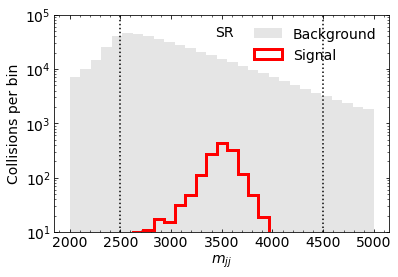

In [7]:
# Define the signal region

SR_low = 2.5
SR_high = 4.5

fig = plt.figure() 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("$m_{jj}$",fontsize=14)
plt.ylabel("Collisions per bin",fontsize=14)


# plot mjj (the first column of dataset_bg and dataset_sig)

_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2000,5000,30),label="Background",color="black",alpha=0.1)
_,_,_=plt.hist(1000*dataset_sig[0:1500][:,0],np.linspace(2000,5000,30),label="Signal",color='red',histtype='step',lw=3)

plt.ylim(10,1e5)
plt.axvline(x=SR_low*1000,color="black",ls=":")
plt.axvline(x=SR_high*1000,color="black",ls=":")
plt.text(3430,4e4,"SR",fontsize=14)
plt.legend(frameon=False,fontsize=14)
plt.yscale("log")
plt.show()

In [8]:
####################
# DATA PREPARATION #
####################

# define signal region
SR_low = 2.5
SR_high = 4.5


# Only keep the events that lie within the signal region
# and only keep the 4 features: "mjOne","mjDelta","tau21jOne","tau21jTwo"
# exclude 'mjj' and 'label'
X_sig_SR = dataset_sig[(dataset_sig[:,0] > SR_low)*(dataset_sig[:,0] < SR_high)][:,1:5]
X_bg_SR = dataset_bg[(dataset_bg[:,0] > SR_low)*(dataset_bg[:,0] < SR_high)][:,1:5]


print('B events in the SR, # features per event :', X_bg_SR.shape)
print('S events in the SR, # features per event :', X_sig_SR.shape)
print('')



# Join for the per-event algorithm
X_4D_phys = np.concatenate([X_sig_SR,X_bg_SR])
Y_4D_phys = np.concatenate([np.ones(len(X_sig_SR)),np.zeros(len(X_bg_SR))])
print('X_4D_phys.shape: ', X_4D_phys.shape)
print('')


# Try standardizing?
scaler1D = preprocessing.StandardScaler().fit(X_4D_phys)
X_4D_phys = scaler1D.transform(X_4D_phys)

# Separate into train and test sets, with 0.5 ratio

X_4D_train_phys, X_4D_val_phys, Y_4D_train_phys, Y_4D_val_phys = train_test_split(X_4D_phys, Y_4D_phys, test_size=0.5)

print('X_4D_train_phys.shape: ', X_4D_train_phys.shape)
print('X_4D_val_phys.shape: ', X_4D_val_phys.shape)
print('Y_4D_train_phys.shape: ', Y_4D_train_phys.shape)
print('')








###############################################################
# BUT WE WANT TO TRAIN WITH THE SAME AMOUNT OF B AND S EVENTS #
###############################################################

# Only keep the events that lie within the signal region
# and only keep the 4 features: "mjOne","mjDelta","tau21jOne","tau21jTwo"
# exclude 'mjj' and 'label'
X_sig_SR_eq = dataset_sig[(dataset_sig[:,0] > SR_low)*(dataset_sig[:,0] < SR_high)][:,1:5]
X_bg_SR_eq = dataset_bg[(dataset_bg[:,0] > SR_low)*(dataset_bg[:,0] < SR_high)][:,1:5]

X_bg_SR_eq = X_bg_SR_eq[:len(X_sig_SR_eq)]

print('')
print('B events in the SR, # features per event :', X_bg_SR_eq.shape)
print('S events in the SR, # features per event :', X_sig_SR_eq.shape)
print('')

# Join for the per-event algorithm
X_4D_phys_eq = np.concatenate([X_sig_SR_eq,X_bg_SR_eq])
Y_4D_phys_eq = np.concatenate([np.ones(len(X_sig_SR_eq)),np.zeros(len(X_bg_SR_eq))])

print('X_4D_phys_eq.shape: ', X_4D_phys_eq.shape)
print('')

scaler1D_eq = preprocessing.StandardScaler().fit(X_4D_phys_eq)
X_4D_phys_eq = scaler1D_eq.transform(X_4D_phys_eq)


B events in the SR, # features per event : (761144, 4)
S events in the SR, # features per event : (99065, 4)

X_4D_phys.shape:  (860209, 4)

X_4D_train_phys.shape:  (430104, 4)
X_4D_val_phys.shape:  (430105, 4)
Y_4D_train_phys.shape:  (430104,)


B events in the SR, # features per event : (99065, 4)
S events in the SR, # features per event : (99065, 4)

X_4D_phys_eq.shape:  (198130, 4)



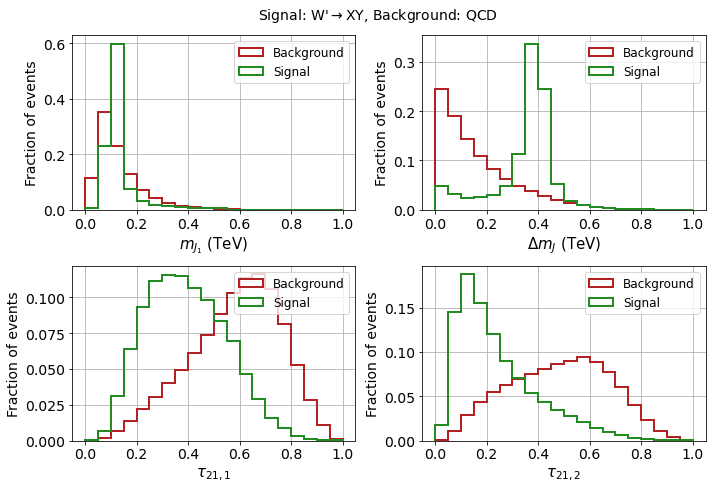

In [9]:
#########################
# PLOT THE 4 PARAMETERS #
#########################


fig_size = [10, 6.5]

fig, axs = plt.subplots(2, 2,sharex=False, sharey=False, figsize=fig_size)

weights = np.ones_like(X_bg_SR[:,0])/float(len(X_bg_SR[:,0]))
axs[0, 0].hist(X_bg_SR[:,0], 20, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label=r"Background")

weights = np.ones_like(X_sig_SR[:,0])/float(len(X_sig_SR[:,0]))
axs[0, 0].hist(X_sig_SR[:,0], 20, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label=r"Signal")

axs[0, 0].tick_params(axis='both', labelsize=14)
axs[0, 0].set_xlabel(r"$m_{J_1}$ (TeV)",fontsize=15)
axs[0, 0].set_ylabel("Fraction of events",fontsize=14)
axs[0, 0].grid()
axs[0, 0].legend(fontsize=12)




weights = np.ones_like(X_bg_SR[:,1])/float(len(X_bg_SR[:,1]))
axs[0, 1].hist(X_bg_SR[:,1], 20, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label=r"Background")

weights = np.ones_like(X_sig_SR[:,1])/float(len(X_sig_SR[:,1]))
axs[0, 1].hist(X_sig_SR[:,1], 20, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label=r"Signal")

axs[0, 1].tick_params(axis='both', labelsize=14)
axs[0, 1].set_xlabel(r"$\Delta m_J$ (TeV)",fontsize=15)
axs[0, 1].set_ylabel("Fraction of events",fontsize=14)
axs[0, 1].grid()
axs[0, 1].legend(fontsize=12)





weights = np.ones_like(X_bg_SR[:,2])/float(len(X_bg_SR[:,2]))
axs[1, 0].hist(X_bg_SR[:,2], 20, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label=r"Background")

weights = np.ones_like(X_sig_SR[:,2])/float(len(X_sig_SR[:,2]))
axs[1, 0].hist(X_sig_SR[:,2], 20, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label=r"Signal")

axs[1, 0].tick_params(axis='both', labelsize=14)
axs[1, 0].set_xlabel(r"$\tau_{21,1}$",fontsize=15)
axs[1, 0].set_ylabel("Fraction of events",fontsize=14)
axs[1, 0].grid()
axs[1, 0].legend(fontsize=12)




weights = np.ones_like(X_bg_SR[:,3])/float(len(X_bg_SR[:,3]))
axs[1, 1].hist(X_bg_SR[:,3], 20, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label=r"Background")

weights = np.ones_like(X_sig_SR[:,3])/float(len(X_sig_SR[:,3]))
axs[1, 1].hist(X_sig_SR[:,3], 20, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label=r"Signal")

axs[1, 1].tick_params(axis='both', labelsize=14)
axs[1, 1].set_xlabel(r"$\tau_{21,2}$",fontsize=15)
axs[1, 1].set_ylabel("Fraction of events",fontsize=14)
axs[1, 1].grid()
axs[1, 1].legend(fontsize=12)


fig.tight_layout()
fig.text(0.53, 1.02, r"Signal: W'$\rightarrow$XY, Background: QCD", va='center', ha='center',fontsize=14)
plt.savefig('images/' + 'Wprime-variables.pdf', format="pdf", bbox_inches="tight")
plt.show()

## CLASSIFIER

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.61574	validation_1-logloss:0.61574
[1]	validation_0-logloss:0.55233	validation_1-logloss:0.55237
[2]	validation_0-logloss:0.49943	validation_1-logloss:0.49949
[3]	validation_0-logloss:0.45480	validation_1-logloss:0.45492
[4]	validation_0-logloss:0.41677	validation_1-logloss:0.41693
[5]	validation_0-logloss:0.38407	validation_1-logloss:0.38426
[6]	validation_0-logloss:0.35570	validation_1-logloss:0.35592
[7]	validation_0-logloss:0.33119	validation_1-logloss:0.33144
[8]	validation_0-logloss:0.30970	validation_1-logloss:0.30996
[9]	validation_0-logloss:0.29087	validation_1-logloss:0.29120
[10]	validation_0-logloss:0.27452	validation_1-logloss:0.27485
[11]	validation_0-logloss:0.25992	validation_1-logloss:0.26031
[12]	validation_0-logloss:0.24702	validation_1-logloss:0.24746
[13]	validation_0-logloss:0.23559	validation_1-logloss:0.23606
[14]	validation_0-logloss:0.22540	validation_1-logloss:0.22590
[15]	validation_0-logloss:0.21639	validation_1-logloss:0.21694
[1

[130]	validation_0-logloss:0.12943	validation_1-logloss:0.13376
[131]	validation_0-logloss:0.12941	validation_1-logloss:0.13376
[132]	validation_0-logloss:0.12938	validation_1-logloss:0.13375
[133]	validation_0-logloss:0.12931	validation_1-logloss:0.13370
[134]	validation_0-logloss:0.12928	validation_1-logloss:0.13369
[135]	validation_0-logloss:0.12925	validation_1-logloss:0.13368
[136]	validation_0-logloss:0.12924	validation_1-logloss:0.13368
[137]	validation_0-logloss:0.12922	validation_1-logloss:0.13368
[138]	validation_0-logloss:0.12920	validation_1-logloss:0.13367
[139]	validation_0-logloss:0.12919	validation_1-logloss:0.13367
[140]	validation_0-logloss:0.12919	validation_1-logloss:0.13367
[141]	validation_0-logloss:0.12914	validation_1-logloss:0.13365
[142]	validation_0-logloss:0.12898	validation_1-logloss:0.13353
[143]	validation_0-logloss:0.12895	validation_1-logloss:0.13352
[144]	validation_0-logloss:0.12893	validation_1-logloss:0.13352
[145]	validation_0-logloss:0.12892	valid

[259]	validation_0-logloss:0.12623	validation_1-logloss:0.13278
[260]	validation_0-logloss:0.12621	validation_1-logloss:0.13278
[261]	validation_0-logloss:0.12620	validation_1-logloss:0.13278
[262]	validation_0-logloss:0.12617	validation_1-logloss:0.13278
[263]	validation_0-logloss:0.12616	validation_1-logloss:0.13278
[264]	validation_0-logloss:0.12614	validation_1-logloss:0.13278
[265]	validation_0-logloss:0.12612	validation_1-logloss:0.13277
[266]	validation_0-logloss:0.12612	validation_1-logloss:0.13277
[267]	validation_0-logloss:0.12610	validation_1-logloss:0.13278
[268]	validation_0-logloss:0.12608	validation_1-logloss:0.13278
[269]	validation_0-logloss:0.12606	validation_1-logloss:0.13278
[270]	validation_0-logloss:0.12601	validation_1-logloss:0.13276
[271]	validation_0-logloss:0.12596	validation_1-logloss:0.13274
[272]	validation_0-logloss:0.12592	validation_1-logloss:0.13273
[273]	validation_0-logloss:0.12589	validation_1-logloss:0.13272
[274]	validation_0-logloss:0.12584	valid

[388]	validation_0-logloss:0.12357	validation_1-logloss:0.13241


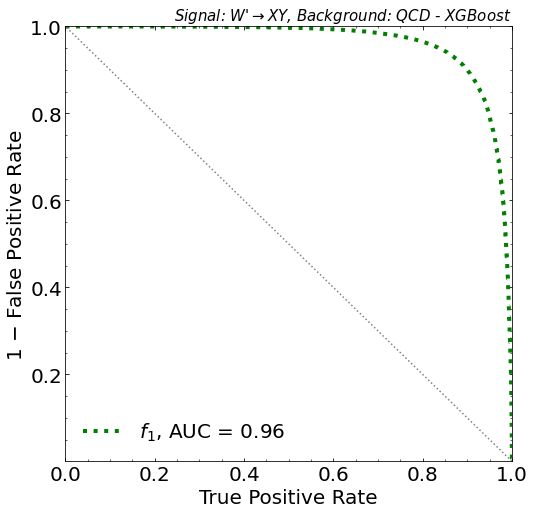

In [10]:
###########
# XGBoost # per-event
###########

# the classifier
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)


 
# fit
classifier.fit(X_4D_train_phys,
               Y_4D_train_phys,
               eval_set=[(X_4D_train_phys, Y_4D_train_phys), (X_4D_val_phys, Y_4D_val_phys)],
               eval_metric='logloss',
               early_stopping_rounds=50,
               verbose=True)

# predictions
scores_4D_B = classifier.predict_proba(X_4D_val_phys).T[1]


# ROC
fpr_4D_xg, tpr_4D_xg, _ = roc_curve(Y_4D_val_phys, scores_4D_B)
roc_auc_xg = auc(fpr_4D_xg, tpr_4D_xg)


fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()


plt.plot(tpr_4D_xg,1-fpr_4D_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="green",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 $-$ False Positive Rate",fontsize=20)
plt.legend(frameon=False)
plt.title(r"Signal: W'$\rightarrow$XY, Background: QCD - XGBoost",loc="right",fontsize=15,style='italic')
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])

plt.legend(frameon=False,fontsize=20)
plt.show()

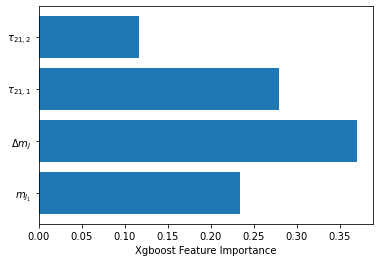

In [11]:
feature_names = np.array(['$m_{J_1}$','$\Delta m_J$',r'$\tau_{21,1}$',r'$\tau_{21,2}$'])
plt.barh(feature_names, classifier.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [12]:
# Let's divide the validation dataset in Signal and Background

X_4D_val_SM = []
X_4D_val_NP = []

for i in range(len(Y_4D_val_phys)):
    if Y_4D_val_phys[i] ==0:
        X_4D_val_SM.append( np.ndarray.tolist( X_4D_val_phys[i]) )
    else:
        X_4D_val_NP.append( np.ndarray.tolist( X_4D_val_phys[i]) )  
        
        
        
# Let's divide the predictions of the validation dataset in Signal and Background

pred_XG_NP_T = []
pred_XG_SM_T = []

for i in range(len(Y_4D_val_phys)):
    if Y_4D_val_phys[i] ==0:
        pred_XG_SM_T.append(scores_4D_B[i])
    else:
        pred_XG_NP_T.append(scores_4D_B[i]) 


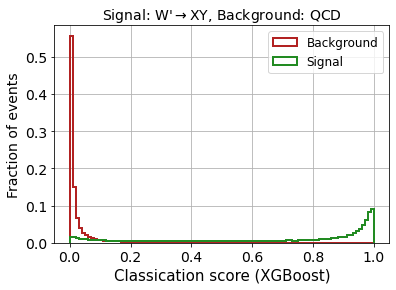


 Classification score interpolation:


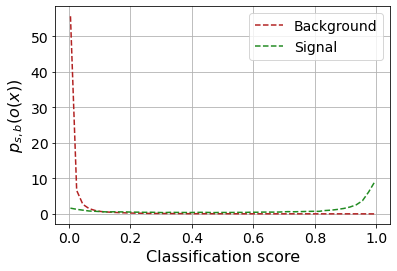

In [13]:
###############################
# p_{s,b}(x) -> p_{s,b}(o(x)) #
###############################

# Histogram of predictions

weights = np.ones_like(pred_XG_SM_T)/float(len(pred_XG_SM_T))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_T, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_T)/float(len(pred_XG_NP_T))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_T, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title(r"Signal: W'$\rightarrow$XY, Background: QCD", fontsize=14)
plt.savefig('images/' + 'Wprime-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





# search the middle possition of each bin

binsSM_mid = []

for i in range(len(binsSM)-1):
    binsSM_mid.append( ((binsSM[i+1]-binsSM[i])/2)+binsSM[i] )
    
    
binsNP_mid = []

for i in range(len(binsNP)-1):
    binsNP_mid.append( ((binsNP[i+1]-binsNP[i])/2)+binsNP[i] )
    
    
# Interpolation,  p_{s,b}(x) -> p_{s,b}(o(x))

fcubic_XG_SM = interp1d(binsSM_mid, nSM, kind='cubic')
fcubic_XG_NP = interp1d(binsNP_mid, nNP, kind='cubic')

# to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=30, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=30, endpoint=True)




# Normalize

# get the width of each bin
bin_width_SM = binsSM[1] - binsSM[0]

# get the width of each bin
bin_width_NP = binsNP[1] - binsNP[0]



def fcubic_XG_SM_norm(x):
    return fcubic_XG_SM(x)/bin_width_SM


def fcubic_XG_NP_norm(x):
    return fcubic_XG_NP(x)/bin_width_NP


print('\n Classification score interpolation:')
# x to plot
xnew_XG_SM = np.linspace(min(binsSM_mid), max(binsSM_mid), num=50, endpoint=True)
xnew_XG_NP = np.linspace(min(binsNP_mid), max(binsNP_mid), num=50, endpoint=True)

plt.plot(xnew_XG_SM, fcubic_XG_SM_norm(xnew_XG_SM), '--', color='firebrick', label='Background')
plt.plot(xnew_XG_NP, fcubic_XG_NP_norm(xnew_XG_NP), '--', color='forestgreen', label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classification score",fontsize=16)
plt.ylabel("$p_{s,b}(o(x))$",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

## MIXED SAMPLES (ensembles with B and S)

## B=50k

In [16]:
##############
# PARAMETERS #
##############

# number of expected signal events per experiment (i.e. per ensemble)
B_expected = 50000

# S/B ratio, expected number of signal events per ensemble
ratio = [0.0001,0.000301,0.0005,0.0007,0.001,0.003,0.005,0.007,0.01] 

# S: number of expected signal events per ensemble
NP_allpoints_original= []

for i in range(len(ratio)):
    NP_allpoints_original.append(int(B_expected*ratio[i]))
    


print('# S eventos en ensembles mixtos: ', NP_allpoints_original)
print('# B eventos en ensembles mixtos: ', B_expected)
print('# TOT eventos en ensembles mixtos: %i + ' % B_expected, NP_allpoints_original)
print('')

print('# B eventos en ensembles SM-only: %i + ' % B_expected, NP_allpoints_original)

# S eventos en ensembles mixtos:  [5, 15, 25, 35, 50, 150, 250, 350, 500]
# B eventos en ensembles mixtos:  50000
# TOT eventos en ensembles mixtos: 50000 +  [5, 15, 25, 35, 50, 150, 250, 350, 500]

# B eventos en ensembles SM-only: 50000 +  [5, 15, 25, 35, 50, 150, 250, 350, 500]


### Machine-Learned Likelihood Method

B_expected:  50000
S_expected:  5
S/$\sqrt{B}$:  0.022360679774997897
n_ensembles (initial):  10000


 If  10001  =  1005    then the proposed range has to be extended
n_ensembles (actual):  9230
prob (bernoulli):  9.999000099990002e-05

 This may take long... 



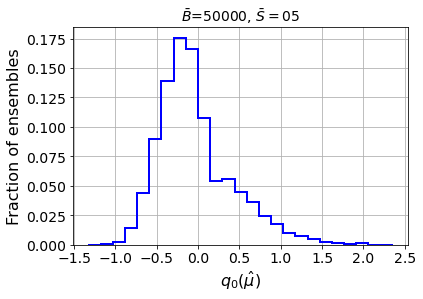

muhat mean:  0.6953521126760563
median q_muhat:  -0.11683270430124493
Z_XG:  0.34180799332555833

 -------------------------------- 

B_expected:  50000
S_expected:  15
S/$\sqrt{B}$:  0.0670820393249937
n_ensembles (initial):  10000


 If  10003  =  1005    then the proposed range has to be extended
n_ensembles (actual):  9231
prob (bernoulli):  0.00029991002699190244

 This may take long... 



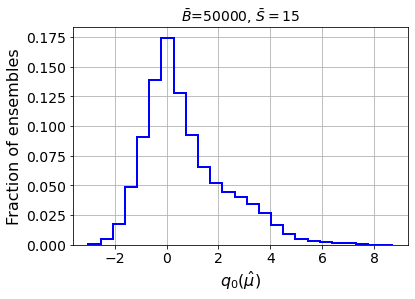

muhat mean:  0.8216986242010615
median q_muhat:  0.35042123652070245
Z_XG:  0.591963881094702

 -------------------------------- 

B_expected:  50000
S_expected:  25
S/$\sqrt{B}$:  0.11180339887498948
n_ensembles (initial):  10000


 If  10005  =  1005    then the proposed range has to be extended
n_ensembles (actual):  9232
prob (bernoulli):  0.0004997501249375312

 This may take long... 



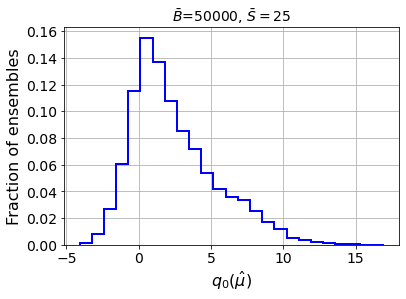

muhat mean:  0.8945623916811091
median q_muhat:  1.7748504336136008
Z_XG:  1.3322351270003359

 -------------------------------- 

B_expected:  50000
S_expected:  35
S/$\sqrt{B}$:  0.15652475842498528
n_ensembles (initial):  10000


 If  10007  =  1005    then the proposed range has to be extended
n_ensembles (actual):  9232
prob (bernoulli):  0.0006995103427600679

 This may take long... 



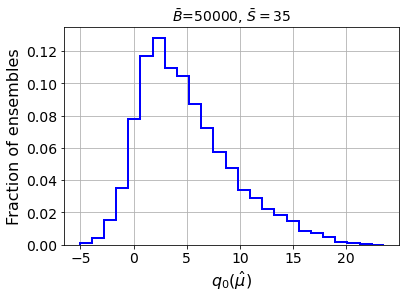

muhat mean:  0.9396663778162911
median q_muhat:  4.22107613646763
Z_XG:  2.054525769239128

 -------------------------------- 

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  10000


 If  10010  =  1005    then the proposed range has to be extended
n_ensembles (actual):  9232
prob (bernoulli):  0.000999000999000999

 This may take long... 



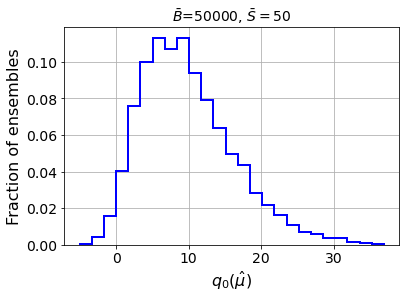

muhat mean:  0.9716096187175043
median q_muhat:  9.003815338203957
Z_XG:  3.0006358223223217

 -------------------------------- 

B_expected:  50000
S_expected:  150
S/$\sqrt{B}$:  0.6708203932499369
n_ensembles (initial):  10000


 If  10030  =  1006    then the proposed range has to be extended
n_ensembles (actual):  9233
prob (bernoulli):  0.0029910269192422734

 This may take long... 



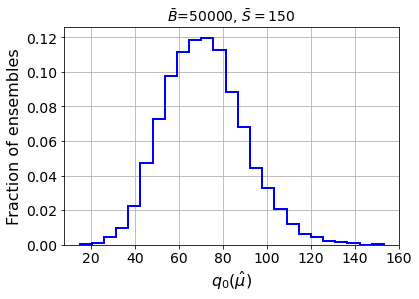

muhat mean:  1.0300660673670528
median q_muhat:  70.83912964468641
Z_XG:  8.416598460464085

 -------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  10000


 If  10050  =  1007    then the proposed range has to be extended
n_ensembles (actual):  9234
prob (bernoulli):  0.004975124378109453

 This may take long... 



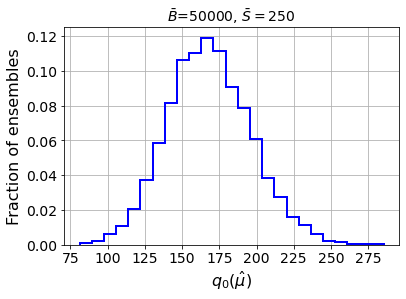

muhat mean:  1.0391054797487544
median q_muhat:  167.43209210368627
Z_XG:  12.939555328668998

 -------------------------------- 

B_expected:  50000
S_expected:  350
S/$\sqrt{B}$:  1.5652475842498528
n_ensembles (initial):  10000


 If  10070  =  1007    then the proposed range has to be extended
n_ensembles (actual):  9234
prob (bernoulli):  0.006951340615690168

 This may take long... 



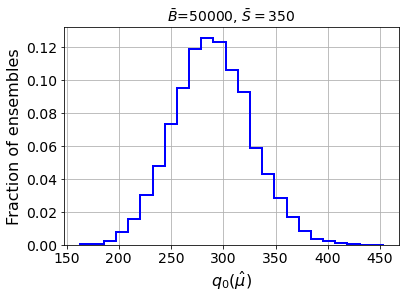

muhat mean:  1.0431773879142299
median q_muhat:  289.0216392434663
Z_XG:  17.00063643642397

 -------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  10000


 If  10100  =  1009    then the proposed range has to be extended
n_ensembles (actual):  9233
prob (bernoulli):  0.009900990099009901

 This may take long... 



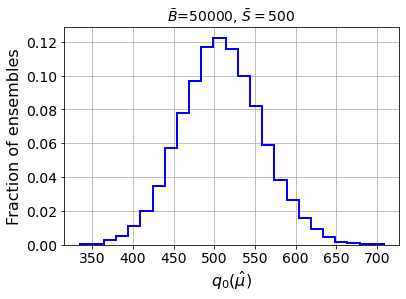

muhat mean:  1.0465179248348313
median q_muhat:  508.2992738603464
Z_XG:  22.54549342685465

 -------------------------------- 



In [17]:
store_muhat_mean_MLL_XG = []
store_Z_MLL_XG = []


# To avoid issues
for kkk in range(len(pred_XG_NP_T)):
    if pred_XG_NP_T[kkk] < min(binsNP_mid):
        pred_XG_NP_T[kkk] = min(binsNP_mid)
    if pred_XG_NP_T[kkk] > max(binsNP_mid):
        pred_XG_NP_T[kkk] = max(binsNP_mid)        

for kkk in range(len(pred_XG_SM_T)):
    if pred_XG_SM_T[kkk] < min(binsSM_mid):
        pred_XG_SM_T[kkk] = min(binsSM_mid)
    if pred_XG_SM_T[kkk] > max(binsSM_mid):
        pred_XG_SM_T[kkk] = max(binsSM_mid)


for iii in range(len(NP_allpoints_original)):
    
    n_ensembles = 10000

    S_expected = NP_allpoints_original[iii]
    
    SsqrtB = S_expected / (B_expected)**0.5
    
       

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected)
    print(r'S/$\sqrt{B}$: ', SsqrtB)
    print('n_ensembles (initial): ', n_ensembles)
    
    print('')
    
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected + B_expected
    
    
    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))

    
    
    
    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:
    
    p_berno = S_expected/(S_expected+B_expected) 
    print('prob (bernoulli): ', p_berno)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######

    
    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_list = []
    q_muhat = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # SIGNAL: classification score for the SIGNAL events in an ensemble
            pred_NP_shuf = np.random.choice(pred_XG_NP_T, list_S_per_ensembles[bb])

            # BACKGROUND: classification score for the BACKGROUND events in an ensemble
            pred_SM_shuf = np.random.choice(pred_XG_SM_T, list_B_per_ensembles[bb])





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( fcubic_XG_SM_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_SM_norm( pred_NP_shuf ) )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( fcubic_XG_NP_norm( pred_SM_shuf ) ) + np.ndarray.tolist( fcubic_XG_NP_norm( pred_NP_shuf ) )




            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat is around 1
            muhat_test = np.arange(0.5, 2, 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 1

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_MLL_XG.append(muhat_mean)
    
    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]

    q_muhat_median = np.median(q_muhat)

    Z_XG = abs(q_muhat_median)**0.5
    store_Z_MLL_XG.append(Z_XG)

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_XG: ', Z_XG)

    print('\n -------------------------------- \n')

In [18]:
print(store_muhat_mean_MLL_XG)
print(store_Z_MLL_XG)

[0.6953521126760563, 0.8216986242010615, 0.8945623916811091, 0.9396663778162911, 0.9716096187175043, 1.0300660673670528, 1.0391054797487544, 1.0431773879142299, 1.0465179248348313]
[0.34180799332555833, 0.591963881094702, 1.3322351270003359, 2.054525769239128, 3.0006358223223217, 8.416598460464085, 12.939555328668998, 17.00063643642397, 22.54549342685465]


In [17]:
# To use if you dont want to run everything again. Its the previous results
# n_ensembles=10k, cubic interpolation, 100 bins

store_muhat_mean_MLL_XG = [0.6953521126760563, 0.8216986242010615, 0.8945623916811091, 0.9396663778162911, 0.9716096187175043, 1.0300660673670528, 1.0391054797487544, 1.0431773879142299, 1.0465179248348313]
store_Z_MLL_XG = [0.34180799332555833, 0.591963881094702, 1.3322351270003359, 2.054525769239128, 3.0006358223223217, 8.416598460464085, 12.939555328668998, 17.00063643642397, 22.54549342685465]

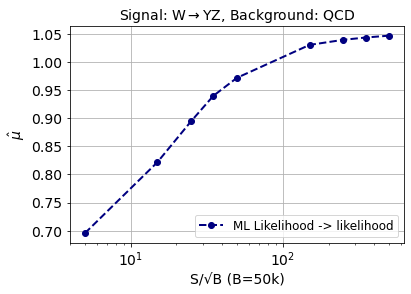

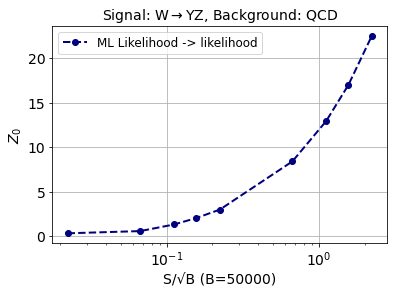

In [18]:
posX = []

for i in range(len(NP_allpoints_original)):
    posX.append(NP_allpoints_original[i]*1./(B_expected)**0.5)

    
    

plt.figure()
lw = 2

plt.plot(NP_allpoints_original, store_muhat_mean_MLL_XG, '--ok', color='navy', lw=lw, label='ML Likelihood -> likelihood')


#plt.xlim([0.01, 100])
#plt.ylim([0., 1.05])
plt.xscale('log')
#plt.axes().set_aspect(0.7)
plt.xlabel('S/√B (B=50k)', fontsize=14)
plt.ylabel('$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title(r'Signal: W$\rightarrow$YZ, Background: QCD', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
#plt.savefig('saved-plots/' + 'DNN-histoMix-SM500000-general-2.png')
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_MLL_XG, '--ok', color='navy', lw=lw, label='ML Likelihood -> likelihood')

#plt.xlim([0.005, 20])
#plt.ylim([0., 1.05])
plt.xscale('log')
#plt.axes().set_aspect(0.7)
plt.xlabel('S/√B (B=%i)' % B_expected, fontsize=14)
plt.ylabel('$Z_{0}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title(r'Signal: W$\rightarrow$YZ, Background: QCD', fontsize=14)
plt.legend(loc="upper left", fontsize=12)
#plt.savefig('saved-plots/' + 'DNN-histoMix-SM500000-general-2.png')
plt.show()


### Working points, counting over 1 bin

In [19]:
WP = [0.25, 0.5, 0.75]

S_sig = [int(ratio[i]*B_expected) for i in range(len(ratio))]

SrootB = [S_sig[i] / (B_expected)**0.5 for i in range(len(ratio))]

print(S_sig)

[5, 15, 25, 35, 50, 150, 250, 350, 500]


In [21]:
SrootB_WP0 = []
SrootB_WP1 = []
SrootB_WP2 = []


# number of background ensembles
B_ensembles = int(len(pred_XG_SM_T)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_T_entero = pred_XG_SM_T[:int(len(pred_XG_SM_T)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_T_entero)):
    if pred_XG_SM_T_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_T_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_T_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

for j in range(len(S_sig)):
    
    # number of signal ensembles
    S_ensembles = int(len(pred_XG_NP_T)/S_sig[j])

    # shorten the number of S events so I get an integer number of ensembles
    pred_XG_NP_T_entero = pred_XG_NP_T[:int(len(pred_XG_NP_T)/S_sig[j]) * S_sig[j]]

    XG_NP_passWP0 = 0
    XG_NP_passWP1 = 0
    XG_NP_passWP2 = 0

    for i in range(len(pred_XG_NP_T_entero)):
        if pred_XG_NP_T_entero[i] > WP[0]:
            XG_NP_passWP0 += 1
        if pred_XG_NP_T_entero[i] > WP[1]:
            XG_NP_passWP1 += 1
        if pred_XG_NP_T_entero[i] > WP[2]:
            XG_NP_passWP2 += 1

            
    # save the results Z_binned after WP
    SrootB_WP0.append( ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5 )
    SrootB_WP1.append( ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5 )
    SrootB_WP2.append( ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5 )
    
    print('S_sig = ', S_sig[j])
    print('WP: 0     S/B**0.5= ', S_sig[j]/(B_expected)**0.5)
    print('WP: ', WP[0], '    S/B**0.5= ', SrootB_WP0[j] )
    print('WP: ', WP[1], '    S/B**0.5= ', SrootB_WP1[j] )
    print('WP: ', WP[2], '    S/B**0.5= ', SrootB_WP2[j] )
    print('------------------------')
    print('')
    
print('SrootB_WP0: ', SrootB_WP0)
print('SrootB_WP1: ', SrootB_WP1)
print('SrootB_WP2: ', SrootB_WP2)

S_sig =  5
WP: 0     S/B**0.5=  0.022360679774997897
WP:  0.25     S/B**0.5=  0.09185837074437708
WP:  0.5     S/B**0.5=  0.12723841121868545
WP:  0.75     S/B**0.5=  0.17036218792591806
------------------------

S_sig =  15
WP: 0     S/B**0.5=  0.0670820393249937
WP:  0.25     S/B**0.5=  0.27557554809827145
WP:  0.5     S/B**0.5=  0.38171025007108583
WP:  0.75     S/B**0.5=  0.5110676333393139
------------------------

S_sig =  25
WP: 0     S/B**0.5=  0.11180339887498948
WP:  0.25     S/B**0.5=  0.45929258016378566
WP:  0.5     S/B**0.5=  0.6361837501184764
WP:  0.75     S/B**0.5=  0.8517793888988565
------------------------

S_sig =  35
WP: 0     S/B**0.5=  0.15652475842498528
WP:  0.25     S/B**0.5=  0.6430116468831204
WP:  0.5     S/B**0.5=  0.8906847941104322
WP:  0.75     S/B**0.5=  1.192567438037452
------------------------

S_sig =  50
WP: 0     S/B**0.5=  0.22360679774997896
WP:  0.25     S/B**0.5=  0.9185851603275713
WP:  0.5     S/B**0.5=  1.2723675002369528
WP:  0.75     S/

In [20]:
# To use if you dont want to run everything again. Its the previous results

SrootB_WP0 = [0.09185837074437708, 0.27557554809827145, 0.45929258016378566, 0.6430116468831204, 0.9185851603275713, 2.7557554809827143, 4.592925801637857, 6.429119632760864, 9.185851603275713]
SrootB_WP1 = [0.12723841121868545, 0.38171025007108583, 0.6361837501184764, 0.8906847941104322, 1.2723675002369528, 3.817102500710858, 6.3618375011847625, 8.90663966547245, 12.723675002369525]
SrootB_WP2 = [0.17036218792591806, 0.5110676333393139, 0.8517793888988565, 1.192567438037452, 1.703558777797713, 5.1106763333931395, 8.517793888988566, 11.924828879819886, 17.03558777797713]

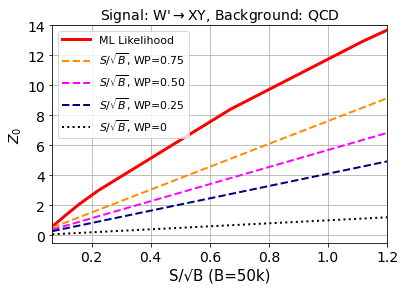

In [23]:
posX = []

for i in range(len(NP_allpoints_original)):
    posX.append(NP_allpoints_original[i]*1./(B_expected)**0.5)
    
    

plt.figure()
lw = 2

plt.plot(posX[1:8], store_Z_MLL_XG[1:8], '-', color='red', lw=3, label='ML Likelihood')
plt.plot(posX[1:8], SrootB_WP2[1:8], '--', color='darkorange', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[2] )
plt.plot(posX[1:8], SrootB_WP1[1:8], '--', color='magenta', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[1] )
plt.plot(posX[1:8], SrootB_WP0[1:8], '--', color='navy', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[0] )
plt.plot(posX[1:8], SrootB[1:8], ':', color='black', lw=lw, label=r'$S/\sqrt{B}$, WP=0' )

plt.xlim([posX[1], 1.2])
plt.ylim([-0.5, 14])
#plt.xscale('log')
#plt.axes().set_aspect(0.7)
plt.xlabel('S/√B (B=50k)', fontsize=15)
plt.ylabel('$Z_{0}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title(r"Signal: W'$\rightarrow$XY, Background: QCD", fontsize=14)
plt.legend(loc="upper left", fontsize=11, handlelength=2.5)
plt.savefig('images/' + 'Wprime-signif.pdf', format="pdf", bbox_inches="tight")
plt.show()


In [64]:
# where is the 5sigma discovery?
f_MLL = interp1d(posX[1:8], store_Z_MLL_XG[1:8], kind='cubic')
print(f_MLL(0.378391))
print(0.378391*((50000)**0.5))

5.000010818035679
84.61079980741229
